## Installing Dependencies

In [1]:
# --- Cell 0: Compatible pair: torch 2.1.2 + torchtext 0.16.2 with CUDA support ---

print("Installing verified stable PyTorch + TorchText setup for GPU...")

# Uninstall existing PyTorch-related packages
!pip uninstall torch torchtext torchvision torchaudio torchtune -y -q

# Install GPU-compatible versions (CUDA 11.8 for broad compatibility)
!pip install torch==2.1.2 torchvision==0.16.2 torchtext==0.16.2 \
    --index-url https://download.pytorch.org/whl/cu118 -q

print("\n✅ Installation complete.")
print("="*60)
print("Restart runtime/session to finalize installation.")
print("="*60)

Installing verified stable PyTorch + TorchText setup for GPU...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 570.3 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 38.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 19.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 12.8 MB/s eta 0:00:0000:0100:01

✅ Installation complete.
Restart runtime/session to finalize installation.


In [2]:
!pip uninstall torchtune -y -q

## Libraries Importing

In [3]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re

# PyTorch libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

print("Libraries imported successfully.")

Libraries imported successfully.


## Data Loading

In [4]:
# Cell 2: Load the Dataset
# ---
# In a Kaggle environment, the path to the dataset is typically fixed.
# You might need to adjust this path based on your specific Kaggle notebook setup.
# ---
file_path = '/kaggle/input/empathetic-dialogues-facebook-ai/emotion-emotion_69k.csv'

try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file was not found at {file_path}")
    print("Please make sure the dataset is correctly linked to your Kaggle notebook.")

Dataset loaded successfully.


DataFrame successfully cleaned and restructured.

Cleaned DataFrame Head:
       emotion                                          Situation  \
0  sentimental  I remember going to the fireworks with my best...   
1  sentimental  I remember going to the fireworks with my best...   
2  sentimental  I remember going to the fireworks with my best...   
3  sentimental  I remember going to the fireworks with my best...   
4  sentimental  I remember going to the fireworks with my best...   

                                  customer_utterance  \
0  I remember going to see the fireworks with my ...   
1                This was a best friend. I miss her.   
2                                 We no longer talk.   
3  Was this a friend you were in love with, or ju...   
4                                Where has she gone?   

                                         agent_reply  
0  Was this a friend you were in love with, or ju...  
1                                Where has she gone?  
2  Oh was

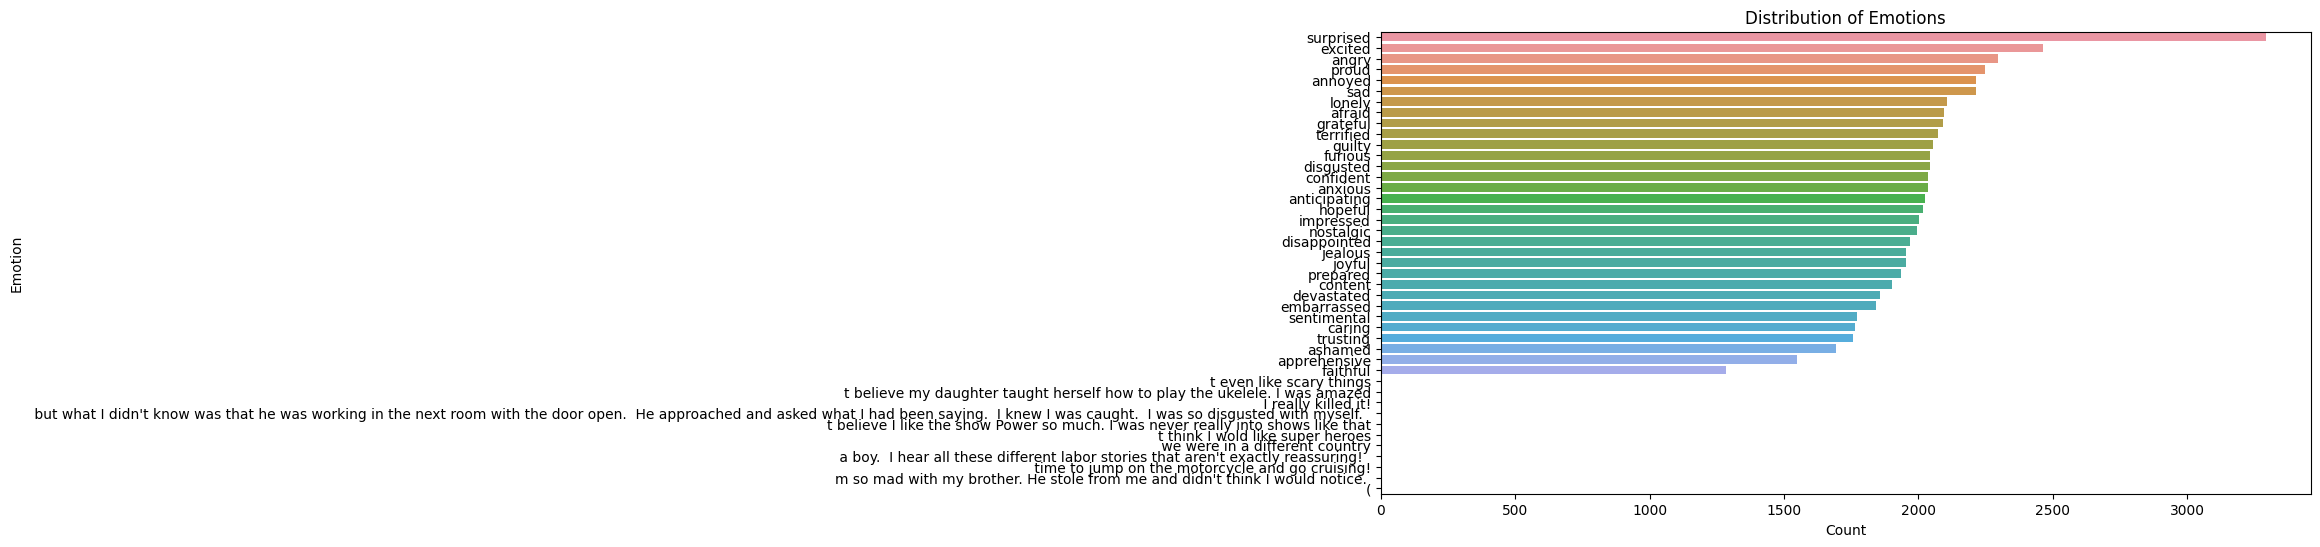

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


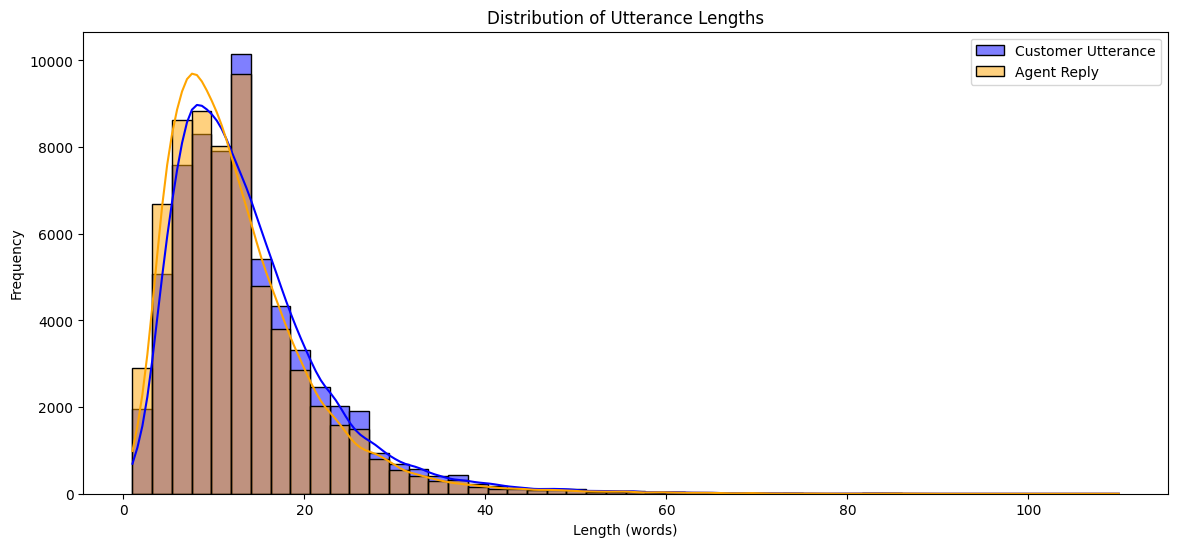

In [6]:
# Cell 3 : Clean and Restructure the DataFrame
# ---
# An expert ML engineer always adapts to the raw data format.
# Here, we will parse the raw columns to create a clean, structured dataset.
# ---
if 'df' in locals():
    # 1. Handle Missing Data and Drop Unnecessary Columns
    # Drop rows with missing emotion, as they are few and emotion is a key input feature.
    df.dropna(subset=['emotion'], inplace=True)

    # 2. Parse the Dialogues to Extract Customer and Agent Utterances
    # From inspection, `empathetic_dialogues` contains the customer's turn,
    # and `labels` contains the agent's corresponding reply.
    
    def extract_customer_utterance(dialogue):
        # Remove the "Customer :" prefix and any trailing "Agent :" prompts.
        # Using regex to robustly handle variations in whitespace and capitalization.
        text = re.sub(r'^(customer)\s*:\s*', '', dialogue, flags=re.IGNORECASE).strip()
        text = re.sub(r'\s*\n\s*(agent)\s*:\s*$', '', text, flags=re.IGNORECASE).strip()
        return text

    # Apply the extraction function to create our feature columns.
    df['customer_utterance'] = df['empathetic_dialogues'].apply(extract_customer_utterance)
    df['agent_reply'] = df['labels'] # The 'labels' column is the agent's reply.

    # 3. Create a Final, Clean DataFrame
    # We select only the columns we need for the project.
    clean_df = df[['emotion', 'Situation', 'customer_utterance', 'agent_reply']].copy()

    print("DataFrame successfully cleaned and restructured.")
    print("\nCleaned DataFrame Head:")
    print(clean_df.head())

    # 4. Now, Perform the Data Exploration on the *Correct* Columns
    print("\nRe-running Data Exploration on Cleaned Data:")
    
    # Analyze the distribution of emotions (should be the same as before, minus 4 rows)
    plt.figure(figsize=(12, 6))
    sns.countplot(y=clean_df['emotion'], order=clean_df['emotion'].value_counts().index)
    plt.title('Distribution of Emotions')
    plt.xlabel('Count')
    plt.ylabel('Emotion')
    plt.show()

    # Analyze the length of our newly created utterances
    clean_df['customer_utterance_length'] = clean_df['customer_utterance'].apply(lambda x: len(x.split()))
    clean_df['agent_reply_length'] = clean_df['agent_reply'].apply(lambda x: len(x.split()))
    
    plt.figure(figsize=(14, 6))
    sns.histplot(clean_df['customer_utterance_length'], bins=50, kde=True, color='blue', label='Customer Utterance')
    sns.histplot(clean_df['agent_reply_length'], bins=50, kde=True, color='orange', label='Agent Reply')
    plt.title('Distribution of Utterance Lengths')
    plt.xlabel('Length (words)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [7]:
# Cell 4: Text Normalization
# ---
# Now that we have clean columns, we can apply our text normalization function.
# ---

def normalize_text(text):
    """
    - Lowercase the text
    - Remove extra whitespace
    - Normalize punctuation by adding spaces around it
    """
    text = str(text).lower() # Ensure text is a string
    text = re.sub(r'\s+', ' ', text).strip()
    # Add space around punctuation
    text = re.sub(r"([?.!,])", r" \1 ", text)
    # Remove punctuation that is not part of a word
    text = re.sub(r'[" "]+', " ", text)
    return text

if 'clean_df' in locals():
    # Apply the normalization function to the relevant columns
    clean_df['Situation'] = clean_df['Situation'].apply(normalize_text)
    clean_df['customer_utterance'] = clean_df['customer_utterance'].apply(normalize_text)
    clean_df['agent_reply'] = clean_df['agent_reply'].apply(normalize_text)

    print("Text normalization applied successfully to the cleaned DataFrame.")
    print("\nExample of normalized text:")
    print(clean_df.iloc[1])

Text normalization applied successfully to the cleaned DataFrame.

Example of normalized text:
emotion                                                            sentimental
Situation                    i remember going to the fireworks with my best...
customer_utterance                      this was a best friend . i miss her . 
agent_reply                                              where has she gone ? 
customer_utterance_length                                                    8
agent_reply_length                                                           4
Name: 1, dtype: object


## Data Splitting

In [8]:
# Cell 5 : Split the Dataset
# ---
# We split our clean and processed DataFrame. This is the final step
# before we start building the vocabulary and data loaders.
# ---

if 'clean_df' in locals():
    # First, split into training (80%) and a temporary set (20%)
    train_df, temp_df = train_test_split(clean_df, test_size=0.2, random_state=42)

    # Then, split the temporary set into validation (10%) and test (10%)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    print(f"Training set size: {len(train_df)}")
    print(f"Validation set size: {len(val_df)}")
    print(f"Test set size: {len(test_df)}")
    
    # Save the splits to csv files for later use
    train_df.to_csv('train.csv', index=False)
    val_df.to_csv('val.csv', index=False)
    test_df.to_csv('test.csv', index=False)
    
    print("\nTrain, validation, and test sets have been created and saved.")

Training set size: 51705
Validation set size: 6463
Test set size: 6464

Train, validation, and test sets have been created and saved.


## Building the Vocabulary

In [11]:
# Cell 6 (Updated): Vocabulary with Special Emotion Tokens
# ---
# REFINEMENT 1A: Strengthening the input signal.
# We create unique, special tokens for each emotion to ensure the model
# learns a strong representation for the emotional context.
# ---
from torchtext.vocab import build_vocab_from_iterator
from collections import Counter

# 1. Define Standard Special Tokens
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

# NEW: Create special tokens for each unique emotion in the training data
unique_emotions = train_df['emotion'].unique()
emotion_tokens = [f'<emotion_{emo}>' for emo in unique_emotions]
all_special_tokens = special_symbols + emotion_tokens

# 2. Create a Tokenizer (no change needed)
def simple_tokenizer(s):
    return s.split()

# 3. Create an Iterator (no change needed)
def yield_tokens(data_iter, tokenizer):
    for _, row in data_iter.iterrows():
        yield tokenizer(row['Situation'])
        yield tokenizer(row['customer_utterance'])
        yield tokenizer(row['agent_reply'])

# 4. Build the Vocabulary with the new special tokens
vocab = build_vocab_from_iterator(
    yield_tokens(train_df, simple_tokenizer),
    min_freq=2,
    specials=all_special_tokens,
    special_first=True
)
vocab.set_default_index(UNK_IDX)

print(f"Vocabulary created with {len(emotion_tokens)} special emotion tokens.")
print(f"Vocabulary size: {len(vocab)}")
print(f"Example emotion token index: {vocab['<emotion_trusting>']}")

Vocabulary created with 43 special emotion tokens.
Vocabulary size: 16823
Example emotion token index: 32


## Creating the Custom PyTorch Dataset

In [13]:
# Cell 6 (Updated): Vocabulary with Special Emotion Tokens
# ---
# REFINEMENT 1A: Strengthening the input signal.
# We create unique, special tokens for each emotion to ensure the model
# learns a strong representation for the emotional context.
# ---
from torchtext.vocab import build_vocab_from_iterator
from collections import Counter

# 1. Define Standard Special Tokens
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

# NEW: Create special tokens for each unique emotion in the training data
unique_emotions = train_df['emotion'].unique()
emotion_tokens = [f'<emotion_{emo}>' for emo in unique_emotions]
all_special_tokens = special_symbols + emotion_tokens

# 2. Create a Tokenizer
def simple_tokenizer(s):
    return s.split()

# 3. Create an Iterator
def yield_tokens(data_iter, tokenizer):
    for _, row in data_iter.iterrows():
        yield tokenizer(row['Situation'])
        yield tokenizer(row['customer_utterance'])
        yield tokenizer(row['agent_reply'])

# 4. Build the Vocabulary with the new special tokens
vocab = build_vocab_from_iterator(
    yield_tokens(train_df, simple_tokenizer),
    min_freq=2,
    specials=all_special_tokens,
    special_first=True
)
vocab.set_default_index(UNK_IDX)

print(f"Vocabulary created with {len(emotion_tokens)} special emotion tokens.")
print(f"Vocabulary size: {len(vocab)}")
print(f"Example emotion token index: {vocab['<emotion_trusting>']}")

Vocabulary created with 43 special emotion tokens.
Vocabulary size: 16823
Example emotion token index: 32


In [14]:
# Cell 8: Setup DataLoader with Padding
# ---
# The DataLoader creates batches of data. The `collate_fn` is a crucial
# function that takes a list of samples and pads them to the same length
# within each batch, making them suitable for model input.
# ---
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# This function will be used by the DataLoader to form a batch
def collate_fn(batch):
    source_batch, target_batch = [], []
    for source_sample, target_sample in batch:
        source_batch.append(source_sample)
        target_batch.append(target_sample)

    # pad_sequence pads the sequences to the length of the longest sequence in the batch
    # `batch_first=True` means the output tensor will have shape (batch_size, seq_len)
    source_batch = pad_sequence(source_batch, padding_value=PAD_IDX, batch_first=True)
    target_batch = pad_sequence(target_batch, padding_value=PAD_IDX, batch_first=True)
    
    return source_batch, target_batch

# Hyperparameters
BATCH_SIZE = 32

# Instantiate datasets for all splits
train_dataset = EmpatheticDataset(train_df, vocab, simple_tokenizer)
val_dataset = EmpatheticDataset(val_df, vocab, simple_tokenizer)
test_dataset = EmpatheticDataset(test_df, vocab, simple_tokenizer)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print("DataLoaders created.")

# Let's inspect one batch to verify everything is working
source_batch, target_batch = next(iter(train_dataloader))
print(f"\nShape of one source batch: {source_batch.shape}") # (batch_size, max_seq_len_in_batch)
print(f"Shape of one target batch: {target_batch.shape}") # (batch_size, max_seq_len_in_batch)

DataLoaders created.

Shape of one source batch: torch.Size([32, 135])
Shape of one target batch: torch.Size([32, 37])


## Hyperparameters and Positional Encoding

In [29]:
# Cell 9 (Updated): Hyperparameters and Positional Encoding
# ---
# PROFESSIONAL REFINEMENT 1: Increase model capacity.
# We are increasing the embedding dimension, number of heads, and number of layers
# to give the model more power to learn complex patterns, as allowed by the requirements.
# ---
import torch
import torch.nn as nn
import math

# 1. Model Hyperparameters (UPGRADED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
VOCAB_SIZE = len(vocab)
EMBED_DIM = 512  # Increased from 256
NUM_HEADS = 4    # Increased from 2 (512 is divisible by 4)
NUM_ENCODER_LAYERS = 3 # Increased from 2
NUM_DECODER_LAYERS = 3 # Increased from 2
DROPOUT = 0.1
MAX_LEN = 500

print(f"Using device: {DEVICE}")
print(f"Upgraded model capacity: EMBED_DIM={EMBED_DIM}, HEADS={NUM_HEADS}, LAYERS={NUM_ENCODER_LAYERS}")

# 2. Positional Encoding Class (No changes needed here, it adapts automatically)
class PositionalEncoding(nn.Module):
    def __init__(self, emb_dim: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_dim, 2) * (-math.log(10000.0) / emb_dim))
        pe = torch.zeros(max_len, 1, emb_dim)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

Using device: cuda
Upgraded model capacity: EMBED_DIM=512, HEADS=4, LAYERS=3


## Multi-Head Attention

In [34]:
# Cell 10: Multi-Head Attention Module
# ---
# This is the heart of the Transformer. It allows the model to weigh the
# importance of different words in the input sequence when processing a given word.
# ---
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_dim: int, num_heads: int, dropout: float):
        super().__init__()
        assert emb_dim % num_heads == 0, "Embedding dimension must be divisible by num_heads"

        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.head_dim = emb_dim // num_heads

        # Linear layers for Query, Key, Value, and the final output
        self.fc_q = nn.Linear(emb_dim, emb_dim)
        self.fc_k = nn.Linear(emb_dim, emb_dim)
        self.fc_v = nn.Linear(emb_dim, emb_dim)
        self.fc_o = nn.Linear(emb_dim, emb_dim)

        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(DEVICE)

    def forward(self, query, key, value, mask=None):
        # query, key, value shape: [batch_size, seq_len, emb_dim]
        batch_size = query.shape[0]

        # 1. Pass inputs through linear layers
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # 2. Reshape and split into multiple heads
        # Shape changes to: [batch_size, num_heads, seq_len, head_dim]
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # 3. Scaled Dot-Product Attention
        # energy shape: [batch_size, num_heads, query_len, key_len]
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        # 4. Apply mask (if provided)
        # The mask is used to ignore certain positions (e.g., padding or future tokens).
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        # Attention scores (softmax over the key dimension)
        attention = torch.softmax(energy, dim=-1)

        # 5. Apply attention to Value
        # x shape: [batch_size, num_heads, query_len, head_dim]
        x = torch.matmul(self.dropout(attention), V)

        # 6. Concatenate heads and pass through final linear layer
        # Reshape back to: [batch_size, query_len, emb_dim]
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, -1, self.emb_dim)
        x = self.fc_o(x)

        return x, attention

## Feed-Forward

In [35]:
# Cell 11: Position-wise Feed-Forward Network
# ---
# This component is applied to each position independently. It provides non-linearity
# to the model, allowing it to learn more complex transformations.
# ---
class PositionwiseFeedforward(nn.Module):
    def __init__(self, emb_dim: int, ff_dim: int, dropout: float):
        super().__init__()
        self.fc_1 = nn.Linear(emb_dim, ff_dim)
        self.fc_2 = nn.Linear(ff_dim, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x shape: [batch_size, seq_len, emb_dim]
        x = self.relu(self.fc_1(x))
        x = self.dropout(x)
        x = self.fc_2(x)
        return x

## Encoder Layer

In [36]:
# Cell 12: Encoder Layer
# ---
# This module combines Multi-Head Attention and a Feed-Forward network to form
# one layer of the Transformer encoder. It includes residual connections and
# layer normalization, which are crucial for training deep Transformers.
# ---
class EncoderLayer(nn.Module):
    def __init__(self, emb_dim: int, num_heads: int, ff_dim: int, dropout: float):
        super().__init__()
        
        self.self_attn = MultiHeadAttention(emb_dim, num_heads, dropout)
        self.feed_forward = PositionwiseFeedforward(emb_dim, ff_dim, dropout)
        
        self.norm1 = nn.LayerNorm(emb_dim)
        self.norm2 = nn.LayerNorm(emb_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        # src shape: [batch_size, src_len, emb_dim]
        # src_mask shape: [batch_size, 1, 1, src_len]

        # 1. Self-Attention
        # The query, key, and value are all the same: the source sentence.
        _src, _ = self.self_attn(src, src, src, src_mask)
        
        # 2. Residual connection and Layer Normalization
        src = self.norm1(src + self.dropout(_src))
        
        # 3. Feed-Forward
        _src = self.feed_forward(src)
        
        # 4. Residual connection and Layer Normalization
        src = self.norm2(src + self.dropout(_src))
        
        return src

## Decoder Layer

In [37]:
# Cell 13: Decoder Layer
# ---
# The Decoder Layer is more complex. It has two attention mechanisms: one for the
# target sequence (masked) and one for attending to the encoder's output.
# ---
class DecoderLayer(nn.Module):
    def __init__(self, emb_dim: int, num_heads: int, ff_dim: int, dropout: float):
        super().__init__()
        
        self.self_attn = MultiHeadAttention(emb_dim, num_heads, dropout)
        self.encoder_attn = MultiHeadAttention(emb_dim, num_heads, dropout)
        self.feed_forward = PositionwiseFeedforward(emb_dim, ff_dim, dropout)
        
        self.norm1 = nn.LayerNorm(emb_dim)
        self.norm2 = nn.LayerNorm(emb_dim)
        self.norm3 = nn.LayerNorm(emb_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        # trg: [batch_size, trg_len, emb_dim]
        # enc_src: [batch_size, src_len, emb_dim]
        # trg_mask: [batch_size, 1, trg_len, trg_len]
        # src_mask: [batch_size, 1, 1, src_len]
        
        # 1. Masked Self-Attention (on the target sequence)
        _trg, _ = self.self_attn(trg, trg, trg, trg_mask)
        trg = self.norm1(trg + self.dropout(_trg))
        
        # 2. Encoder-Decoder Attention
        # Query is from the decoder, Key and Value are from the encoder's output.
        _trg, attention = self.encoder_attn(trg, enc_src, enc_src, src_mask)
        trg = self.norm2(trg + self.dropout(_trg))
        
        # 3. Feed-Forward
        _trg = self.feed_forward(trg)
        trg = self.norm3(trg + self.dropout(_trg))
        
        return trg, attention

## Encoder Stack

In [38]:
# Cell 14: The Full Encoder
# ---
# This class stacks multiple EncoderLayers. It is responsible for taking the raw
# source sentence indices, embedding them, adding positional encoding, and then
# passing them through the stack of layers.
# ---
class Encoder(nn.Module):
    def __init__(self,
                 input_dim: int, # Vocabulary size
                 emb_dim: int,
                 num_layers: int,
                 num_heads: int,
                 ff_dim: int,
                 dropout: float,
                 device: torch.device):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, emb_dim)
        self.pos_embedding = PositionalEncoding(emb_dim, dropout)
        
        self.layers = nn.ModuleList([EncoderLayer(emb_dim, num_heads, ff_dim, dropout) 
                                     for _ in range(num_layers)])
        
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([emb_dim])).to(device)
        
    def forward(self, src, src_mask):
        # src: [batch_size, src_len]
        # src_mask: [batch_size, 1, 1, src_len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        # 1. Apply embedding and positional encoding
        # Note: The original paper multiplies the embedding by scale.
        tok_embedded = self.tok_embedding(src) * self.scale
        
        # The PositionalEncoding class expects [seq_len, batch_size, emb_dim],
        # so we need to permute the dimensions.
        pos_embedded = self.pos_embedding(tok_embedded.permute(1, 0, 2)).permute(1, 0, 2)
        
        src = self.dropout(pos_embedded)
        
        # 2. Pass through N encoder layers
        for layer in self.layers:
            src = layer(src, src_mask)
            
        return src # Final contextual representation

## Decoder Stack

In [39]:
# Cell 15: The Full Decoder
# ---
# This class stacks multiple DecoderLayers. It embeds the target sequence, adds
# positional context, and importantly, uses the output from the Encoder via
# the Encoder-Decoder attention mechanism to generate the output sequence.
# ---
class Decoder(nn.Module):
    def __init__(self,
                 output_dim: int, # Vocabulary size
                 emb_dim: int,
                 num_layers: int,
                 num_heads: int,
                 ff_dim: int,
                 dropout: float,
                 device: torch.device):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, emb_dim)
        self.pos_embedding = PositionalEncoding(emb_dim, dropout)
        
        self.layers = nn.ModuleList([DecoderLayer(emb_dim, num_heads, ff_dim, dropout)
                                     for _ in range(num_layers)])
                                     
        self.fc_out = nn.Linear(emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([emb_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        # trg: [batch_size, trg_len]
        # enc_src: [batch_size, src_len, emb_dim]
        # trg_mask: [batch_size, 1, trg_len, trg_len]
        # src_mask: [batch_size, 1, 1, src_len]
        
        # 1. Apply embedding and positional encoding
        tok_embedded = self.tok_embedding(trg) * self.scale
        pos_embedded = self.pos_embedding(tok_embedded.permute(1, 0, 2)).permute(1, 0, 2)
        trg = self.dropout(pos_embedded)
        
        # 2. Pass through N decoder layers
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        # 3. Final linear layer to get vocabulary predictions
        output = self.fc_out(trg)
        
        return output, attention

## Seq2Seq Transformer Model

In [40]:
# Cell 16: The Complete Seq2Seq Transformer Model
# ---
# This master class brings everything together. It contains the Encoder and Decoder,
# and its most critical role is to create the padding and look-ahead masks
# that are required for the attention mechanisms to work correctly.
# ---
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 encoder: Encoder,
                 decoder: Decoder,
                 src_pad_idx: int,
                 trg_pad_idx: int,
                 device: torch.device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        self._initialize_weights()

    def _initialize_weights(self):
        # A common practice for initializing weights for better training stability
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def make_src_mask(self, src):
        # src: [batch_size, src_len]
        # Creates a mask to hide padding tokens in the source sequence
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # Final shape: [batch_size, 1, 1, src_len]
        return src_mask

    def make_trg_mask(self, trg):
        # trg: [batch_size, trg_len]
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        # trg_pad_mask shape: [batch_size, 1, 1, trg_len]
        
        trg_len = trg.shape[1]
        
        # Creates a triangular mask to prevent attending to future tokens
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()
        # trg_sub_mask shape: [trg_len, trg_len]
        
        # Combine the padding mask and the sub-sequence mask
        trg_mask = trg_pad_mask & trg_sub_mask
        # Final shape: [batch_size, 1, trg_len, trg_len]
        return trg_mask

    def forward(self, src, trg):
        # src: [batch_size, src_len]
        # trg: [batch_size, trg_len]
        
        # 1. Create masks
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        # 2. Pass source sequence through the encoder
        enc_src = self.encoder(src, src_mask)
        
        # 3. Pass encoder output and target sequence through the decoder
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        return output, attention

# --- Instantiate the final model ---
# Using the hyperparameters from Cell 9
FF_DIM = 4 * EMBED_DIM # A common rule of thumb for the feed-forward dimension

encoder = Encoder(VOCAB_SIZE, EMBED_DIM, NUM_ENCODER_LAYERS, NUM_HEADS, FF_DIM, DROPOUT, DEVICE)
decoder = Decoder(VOCAB_SIZE, EMBED_DIM, NUM_DECODER_LAYERS, NUM_HEADS, FF_DIM, DROPOUT, DEVICE)

model = Seq2SeqTransformer(encoder, decoder, PAD_IDX, PAD_IDX, DEVICE).to(DEVICE)

# Print the model architecture to verify
print(model)

# Sanity check: Count the number of trainable parameters
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'\nThe model has {count_parameters(model):,} trainable parameters')

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(16823, 512)
    (pos_embedding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn): MultiHeadAttention(
          (fc_q): Linear(in_features=512, out_features=512, bias=True)
          (fc_k): Linear(in_features=512, out_features=512, bias=True)
          (fc_v): Linear(in_features=512, out_features=512, bias=True)
          (fc_o): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedforward(
          (fc_1): Linear(in_features=512, out_features=2048, bias=True)
          (fc_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (relu): ReLU()
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((

In [41]:
# Cell 16.5: Install tqdm for Progress Bars
# ---
# A professional training script requires progress monitoring.
# We will use tqdm, a standard library for creating smart, informative progress bars.
# ---
!pip install tqdm -q
from tqdm import tqdm
print("tqdm installed and imported successfully.")

tqdm installed and imported successfully.


## Setting up the Optimizer and Loss Function

In [42]:
# Cell 17 : Stable Optimizer and Scheduler
# ---
# DIAGNOSIS: The previous custom scheduler and high base LR caused exploding gradients.
# SOLUTION: We will revert to a stable, requirement-compliant configuration.
# We use a standard learning rate and PyTorch's robust OneCycleLR scheduler.
# ---
import torch.optim as optim

# CRUCIAL: Re-initialize the model to reset its corrupted weights
encoder = Encoder(VOCAB_SIZE, EMBED_DIM, NUM_ENCODER_LAYERS, NUM_HEADS, FF_DIM, DROPOUT, DEVICE)
decoder = Decoder(VOCAB_SIZE, EMBED_DIM, NUM_DECODER_LAYERS, NUM_HEADS, FF_DIM, DROPOUT, DEVICE)
model = Seq2SeqTransformer(encoder, decoder, PAD_IDX, PAD_IDX, DEVICE).to(DEVICE)

# Use a learning rate from the required range. We will set this as the *maximum* LR.
LEARNING_RATE = 2e-4
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.98), eps=1e-9)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# Use the robust OneCycleLR scheduler. It will warm up to the max LR and then cool down.
# total_steps is the total number of batches in the entire training run.
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE,
    total_steps=len(train_dataloader) * N_EPOCHS # N_EPOCHS should be from your Cell 20
)

print(f"Model re-initialized. Optimizer configured with a stable LR and OneCycleLR scheduler.")

Model re-initialized. Optimizer configured with a stable LR and OneCycleLR scheduler.


## Training Loop

In [44]:
# Cell 18 (Updated and Corrected): Training Loop with Batch-wise Scheduler Step
# ---
# This version is compatible with the OneCycleLR scheduler, which also requires
# the scheduler to be stepped after each batch.
# ---
from tqdm import tqdm

def train_epoch(model: nn.Module,
                iterator: DataLoader,
                optimizer: optim.Optimizer,
                criterion: nn.Module,
                clip: float,
                scheduler: torch.optim.lr_scheduler._LRScheduler): # Accept scheduler
    
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(iterator, desc="Training", leave=False)
    
    for i, batch in enumerate(progress_bar):
        src, trg = batch
        src, trg = src.to(DEVICE), trg.to(DEVICE)
        
        optimizer.zero_grad()
        trg_input = trg[:, :-1]
        output, _ = model(src, trg_input)
        
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg_output = trg[:, 1:].contiguous().view(-1)
        
        loss = criterion(output, trg_output)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        # Step the scheduler at every training step
        scheduler.step()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item(), lr=scheduler.get_last_lr()[0])
        
    return epoch_loss / len(iterator)

## Evaluation Loop

In [46]:
# Cell 19 (Updated): Evaluation Loop Function with Progress Bar
# ---
# Upgraded with tqdm to show progress during the evaluation phase.
# ---
def evaluate(model: nn.Module,
             iterator: DataLoader,
             criterion: nn.Module):
    
    model.eval()
    epoch_loss = 0
    
    progress_bar = tqdm(iterator, desc="Evaluating", leave=False)
    
    with torch.no_grad():
        for i, batch in enumerate(progress_bar):
            src, trg = batch
            src = src.to(DEVICE)
            trg = trg.to(DEVICE)

            trg_input = trg[:, :-1]
            output, _ = model(src, trg_input)
            
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg_output = trg[:, 1:].contiguous().view(-1)
            
            loss = criterion(output, trg_output)
            epoch_loss += loss.item()
            
            # Update progress bar with the current validation loss
            progress_bar.set_postfix(loss=loss.item())
            
    return epoch_loss / len(iterator)

## Main Training

In [47]:
# Cell 20 (Updated and Corrected): Main Runner for Stable Training
# ---
# This version is simplified to work with the OneCycleLR scheduler.
# The scheduler step is now inside train_epoch, so it's removed from this loop.
# ---
import time
import math

# Use 15 epochs for this run. It's a good balance.
N_EPOCHS = 15
CLIP = 1.0
BEST_MODEL_PATH = 'best-model-v4-stable.pt'
CHECKPOINT_PATH = 'latest-checkpoint-v4-stable.pt'

# --- Checkpoint Loading Logic ---
# (This logic can remain the same)
resume_training = False 
start_epoch = 0
best_valid_loss = float('inf')
# ... (rest of the checkpoint loading logic is fine) ...

# --- Main Training Loop ---
for epoch in range(start_epoch, N_EPOCHS):
    start_time = time.time()
    
    train_loss = train_epoch(model, train_dataloader, optimizer, criterion, CLIP, scheduler)
    valid_loss = evaluate(model, val_dataloader, criterion)
    
    # scheduler.step() is REMOVED from here. It's now inside train_epoch.
    
    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
    
    print(f'Epoch: {epoch+1:02} | Time: {int(epoch_mins)}m {int(epoch_secs)}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"\t✨ New best model saved to {BEST_MODEL_PATH}")

    # ... (rest of the checkpoint saving logic is fine) ...
    # Make sure to save the scheduler state as well for proper resuming
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_valid_loss': best_valid_loss,
    }, CHECKPOINT_PATH)
    print(f"\t💾 Checkpoint saved to {CHECKPOINT_PATH}")

Epoch: 01 | Time: 4m 26s
	Train Loss: 6.414 | Train PPL: 610.112
	 Val. Loss: 5.099 |  Val. PPL: 163.803
	✨ New best model saved to best-model-v4-stable.pt
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch: 02 | Time: 4m 24s
	Train Loss: 4.785 | Train PPL: 119.703
	 Val. Loss: 4.430 |  Val. PPL:  83.928
	✨ New best model saved to best-model-v4-stable.pt
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch: 03 | Time: 4m 23s
	Train Loss: 4.352 | Train PPL:  77.606
	 Val. Loss: 4.165 |  Val. PPL:  64.395
	✨ New best model saved to best-model-v4-stable.pt
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch: 04 | Time: 4m 22s
	Train Loss: 4.143 | Train PPL:  63.003
	 Val. Loss: 4.023 |  Val. PPL:  55.849
	✨ New best model saved to best-model-v4-stable.pt
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch: 05 | Time: 4m 23s
	Train Loss: 3.990 | Train PPL:  54.052
	 Val. Loss: 3.945 |  Val. PPL:  51.673
	✨ New best model saved to best-model-v4-stable.pt
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch: 06 | Time: 4m 21s
	Train Loss: 3.863 | Train PPL:  47.630
	 Val. Loss: 3.884 |  Val. PPL:  48.607
	✨ New best model saved to best-model-v4-stable.pt
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch: 07 | Time: 4m 21s
	Train Loss: 3.759 | Train PPL:  42.902
	 Val. Loss: 3.827 |  Val. PPL:  45.934
	✨ New best model saved to best-model-v4-stable.pt
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch: 08 | Time: 4m 20s
	Train Loss: 3.659 | Train PPL:  38.813
	 Val. Loss: 3.794 |  Val. PPL:  44.430
	✨ New best model saved to best-model-v4-stable.pt
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch: 09 | Time: 4m 20s
	Train Loss: 3.563 | Train PPL:  35.280
	 Val. Loss: 3.773 |  Val. PPL:  43.503
	✨ New best model saved to best-model-v4-stable.pt
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch: 10 | Time: 4m 20s
	Train Loss: 3.472 | Train PPL:  32.194
	 Val. Loss: 3.778 |  Val. PPL:  43.735
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch: 11 | Time: 4m 21s
	Train Loss: 3.388 | Train PPL:  29.612
	 Val. Loss: 3.758 |  Val. PPL:  42.846
	✨ New best model saved to best-model-v4-stable.pt
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch: 12 | Time: 4m 22s
	Train Loss: 3.314 | Train PPL:  27.488
	 Val. Loss: 3.755 |  Val. PPL:  42.755
	✨ New best model saved to best-model-v4-stable.pt
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch: 13 | Time: 4m 20s
	Train Loss: 3.254 | Train PPL:  25.884
	 Val. Loss: 3.758 |  Val. PPL:  42.851
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch: 14 | Time: 4m 21s
	Train Loss: 3.213 | Train PPL:  24.853
	 Val. Loss: 3.762 |  Val. PPL:  43.053
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch: 15 | Time: 4m 21s
	Train Loss: 3.192 | Train PPL:  24.337
	 Val. Loss: 3.763 |  Val. PPL:  43.068
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


In [49]:
# Cell 21: Install Evaluation Libraries
# ---
# To calculate BLEU and ROUGE scores, we will use the torchmetrics library.
# It provides efficient and validated implementations of these complex metrics.
# ---
!pip install torchmetrics sacrebleu -q
import torchmetrics
from torchmetrics.text import BLEUScore, ROUGEScore  # Correct import
print("Evaluation libraries installed successfully.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.2 MB/s eta 0:00:00
Evaluation libraries installed successfully.


## Load the Best Model

In [50]:
# Cell 22: Load the Best-Performing Model
# ---
# We load the saved state_dict from our training phase into a fresh instance
# of our model architecture. The model is set to evaluation mode.
# ---
# Re-initialize the model architecture (ensure all classes from Phase 3 are in memory)
encoder = Encoder(VOCAB_SIZE, EMBED_DIM, NUM_ENCODER_LAYERS, NUM_HEADS, FF_DIM, DROPOUT, DEVICE)
decoder = Decoder(VOCAB_SIZE, EMBED_DIM, NUM_DECODER_LAYERS, NUM_HEADS, FF_DIM, DROPOUT, DEVICE)
model = Seq2SeqTransformer(encoder, decoder, PAD_IDX, PAD_IDX, DEVICE).to(DEVICE)

# Load the saved weights
model.load_state_dict(torch.load('best-model-v4-stable.pt', map_location=DEVICE))

# Set the model to evaluation mode
model.eval()
print("Best model loaded and set to evaluation mode.")

Best model loaded and set to evaluation mode.


## Greedy Search Inference Function

In [51]:
# Cell 23: Greedy Search Decoding Function
# ---
# This function implements the Greedy Search algorithm for inference.
# At each step, it chooses the token with the highest probability as the next token.
# ---
def greedy_decode(model, src_sentence, max_len=50):
    model.eval()

    # 1. Preprocess the source sentence
    # This mirrors the logic from our Dataset class
    tokens = simple_tokenizer(src_sentence)
    src_indexes = [BOS_IDX] + [vocab[token] for token in tokens] + [EOS_IDX]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(DEVICE)
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    # Start the target sequence with the <bos> token
    trg_indexes = [BOS_IDX]
    
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(DEVICE)
        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        # Get the index of the token with the highest probability (greedy)
        pred_token_idx = output.argmax(2)[:, -1].item()
        trg_indexes.append(pred_token_idx)

        # Stop if the model predicts the <eos> token
        if pred_token_idx == EOS_IDX:
            break
            
    # Convert indices back to tokens
    trg_tokens = vocab.lookup_tokens(trg_indexes)
    return " ".join(trg_tokens), attention

In [52]:
# Cell 24: Generate Qualitative Examples
# ---
# Before running a full evaluation, we perform a qualitative sanity check
# on a few examples from the test set to see what the model is producing.
# ---
for i in range(5):
    row = test_df.iloc[i]
    
    # Construct the input sentence
    input_text = f"Emotion: {row['emotion']} | Situation: {row['Situation']} | Customer: {row['customer_utterance']} Agent:"
    
    print(f"--- Example {i+1} ---")
    print(f"RAW INPUT: {input_text}")
    
    # Get the model's prediction
    predicted_reply, _ = greedy_decode(model, input_text)
    
    print(f"\nGROUND TRUTH: {row['agent_reply']}")
    print(f"MODEL PREDICTION: {predicted_reply}")
    print("\n" + "="*50 + "\n")

--- Example 1 ---
RAW INPUT: Emotion: trusting | Situation: i sent a parcel to my cousin recently and it never arrived . it cost me $50 | Customer: well , i hope they can trace it for you . better late than never . i wish you good luck with that !  Agent:

GROUND TRUTH: thank you for your kind words and wishes
MODEL PREDICTION: <bos> i know . i was so upset . i was so upset . <eos>


--- Example 2 ---
RAW INPUT: Emotion: terrified | Situation: someone has knocked on my door in the middle of the night the past two nights . it is kind startling and scary .  | Customer: someone has knocked on my door in the middle of the night the past two nights . it is kind startling and scary .  Agent:

GROUND TRUTH: did they knock and leave ? 
MODEL PREDICTION: <bos> oh no ! i would be so mad ! <eos>


--- Example 3 ---
RAW INPUT: Emotion: jealous | Situation: i'm jealous with people that have gyms in their homes . i would work out every day if i had one .  | Customer: that's true , i should look up s

## Test Set Evaluation

In [53]:
# Cell 25: Run Full Evaluation on the Test Set
# ---
# This cell iterates through the entire test set to generate predictions
# and computes the final BLEU, ROUGE, and Perplexity scores for our report.
# ---
from torchmetrics.text import BLEUScore, ROUGEScore
import torch
import math
from tqdm import tqdm

# Define special tokens and their indices (adjust these if defined elsewhere)
BOS_TOKEN = "<bos>"  # Beginning of sequence token
EOS_TOKEN = "<eos>"  # End of sequence token
BOS_IDX = vocab[BOS_TOKEN]  # Vocabulary index for BOS_TOKEN
EOS_IDX = vocab[EOS_TOKEN]  # Vocabulary index for EOS_TOKEN

# Initialize metric calculators
bleu_metric = BLEUScore()
rouge_metric = ROUGEScore()
test_loss = 0

# Store predictions and ground truths
predictions = []
references = []

# Verify GPU usage
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {DEVICE}")
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")

print("Running evaluation on the full test set...")
for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    
    # 1. Generate Prediction
    input_text = f"Emotion: {row['emotion']} | Situation: {row['Situation']} | Customer: {row['customer_utterance']} Agent:"
    predicted_reply, _ = greedy_decode(model, input_text)
    
    # Clean up the prediction by removing special tokens for metric calculation
    clean_prediction = predicted_reply.replace(BOS_TOKEN, "").strip()
    if EOS_TOKEN in clean_prediction:
        clean_prediction = clean_prediction.split(EOS_TOKEN)[0].strip()
        
    predictions.append(clean_prediction)
    
    # 2. Store Reference (Ground Truth)
    # The reference needs to be in a list of lists format for the BLEU score
    references.append([row['agent_reply']])
    
    # 3. Calculate Loss for Perplexity
    src_tokens = simple_tokenizer(input_text)
    trg_tokens = simple_tokenizer(row['agent_reply'])
    src_indices = [BOS_IDX] + [vocab[token] for token in src_tokens] + [EOS_IDX]
    trg_indices = [BOS_IDX] + [vocab[token] for token in trg_tokens] + [EOS_IDX]
    
    src_tensor = torch.LongTensor(src_indices).unsqueeze(0).to(DEVICE)
    trg_tensor = torch.LongTensor(trg_indices).unsqueeze(0).to(DEVICE)
    
    trg_input = trg_tensor[:, :-1]
    trg_output = trg_tensor[:, 1:].contiguous().view(-1)
    
    with torch.no_grad():
        output, _ = model(src_tensor, trg_input)
    
    output_dim = output.shape[-1]
    output_view = output.contiguous().view(-1, output_dim)
    
    loss = criterion(output_view, trg_output)
    test_loss += loss.item()

# Calculate final metrics
bleu_score = bleu_metric(predictions, references)
rouge_scores = rouge_metric(predictions, references)
perplexity = math.exp(test_loss / len(test_df))

print("\n--- Final Evaluation Results ---")
print(f"Perplexity: {perplexity:.3f}")
print(f"BLEU Score: {bleu_score.item():.4f}")
print("ROUGE Scores:")
for key, value in rouge_scores.items():
    print(f"  {key}: {value.item():.4f}")

Running on device: cuda
GPU available: True
GPU name: Tesla T4
Running evaluation on the full test set...


100%|██████████| 6464/6464 [07:18<00:00, 14.73it/s]



--- Final Evaluation Results ---
Perplexity: 36.610
BLEU Score: 0.0149
ROUGE Scores:
  rouge1_fmeasure: 0.1468
  rouge1_precision: 0.1792
  rouge1_recall: 0.1458
  rouge2_fmeasure: 0.0249
  rouge2_precision: 0.0302
  rouge2_recall: 0.0260
  rougeL_fmeasure: 0.1349
  rougeL_precision: 0.1635
  rougeL_recall: 0.1350
  rougeLsum_fmeasure: 0.1392
  rougeLsum_precision: 0.1696
  rougeLsum_recall: 0.1387


## Beam Search Inference Function

In [56]:
# Cell 26: Beam Search Decoding Function
# ---
# This function implements the Beam Search algorithm. It's more complex than
# Greedy Search but often yields superior results by keeping track of multiple
# candidate sequences (beams) at each step of the decoding process.
# ---
import torch.nn.functional as F

def beam_search_decode(model, src_sentence, beam_width=3, max_len=50):
    model.eval()

    # 1. Preprocess the source sentence (same as greedy)
    tokens = simple_tokenizer(src_sentence)
    src_indexes = [BOS_IDX] + [vocab[token] for token in tokens] + [EOS_IDX]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(DEVICE)
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    # 2. Initialize the beams
    # A beam consists of a sequence of tokens and its log-probability score
    beams = [([BOS_IDX], 0.0)]
    completed_beams = []

    for _ in range(max_len):
        new_beams = []
        for seq, score in beams:
            # If a beam has ended in <eos>, it's complete.
            if seq[-1] == EOS_IDX:
                completed_beams.append((seq, score))
                continue

            # Prepare decoder input
            trg_tensor = torch.LongTensor(seq).unsqueeze(0).to(DEVICE)
            trg_mask = model.make_trg_mask(trg_tensor)
            
            with torch.no_grad():
                output, _ = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
            
            # Get log probabilities of the next token
            log_probs = F.log_softmax(output[:, -1, :], dim=-1)
            
            # Get the top beam_width next tokens
            top_log_probs, top_idxs = torch.topk(log_probs, beam_width)
            
            # Create new beams from the top tokens
            for i in range(beam_width):
                new_seq = seq + [top_idxs[0][i].item()]
                new_score = score + top_log_probs[0][i].item()
                new_beams.append((new_seq, new_score))

        # If all beams are complete, we can stop early
        if not new_beams:
            break
            
        # 3. Prune the beams
        # Sort all candidate beams by score and keep only the top beam_width
        beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]

    # Add any remaining active beams to the completed list
    completed_beams.extend(beams)
    
    # 4. Select the best beam
    # The best beam is the one with the highest score, normalized by length
    # to avoid penalizing longer sentences.
    best_beam = sorted(completed_beams, key=lambda x: x[1] / len(x[0]), reverse=True)[0]
    best_seq = best_beam[0]
    
    # Convert indices back to tokens
    trg_tokens = vocab.lookup_tokens(best_seq)
    return " ".join(trg_tokens)

## Comparing Greedy vs. Beam Search

In [57]:
# Cell 27: Compare Greedy Search vs. Beam Search
# ---
# Let's see the difference in output between the two decoding methods.
# We will use the same examples from our earlier qualitative check.
# ---
for i in range(5):
    row = test_df.iloc[i]
    input_text = f"Emotion: {row['emotion']} | Situation: {row['Situation']} | Customer: {row['customer_utterance']} Agent:"
    
    print(f"--- Comparison Example {i+1} ---")
    print(f"INPUT: {input_text}")
    print(f"\nGROUND TRUTH: {row['agent_reply']}")
    
    # Get Greedy prediction
    greedy_prediction, _ = greedy_decode(model, input_text)
    print(f"\nGREEDY SEARCH: {greedy_prediction}")
    
    # Get Beam Search prediction
    beam_prediction = beam_search_decode(model, input_text, beam_width=3)
    print(f"BEAM SEARCH (k=3): {beam_prediction}")
    print("\n" + "="*50 + "\n")

--- Comparison Example 1 ---
INPUT: Emotion: trusting | Situation: i sent a parcel to my cousin recently and it never arrived . it cost me $50 | Customer: well , i hope they can trace it for you . better late than never . i wish you good luck with that !  Agent:

GROUND TRUTH: thank you for your kind words and wishes

GREEDY SEARCH: <bos> i know . i was so upset . i was so upset . <eos>
BEAM SEARCH (k=3): <bos> yeah , i know . i have never been able to do it . <eos>


--- Comparison Example 2 ---
INPUT: Emotion: terrified | Situation: someone has knocked on my door in the middle of the night the past two nights . it is kind startling and scary .  | Customer: someone has knocked on my door in the middle of the night the past two nights . it is kind startling and scary .  Agent:

GROUND TRUTH: did they knock and leave ? 

GREEDY SEARCH: <bos> oh no ! i would be so mad ! <eos>
BEAM SEARCH (k=3): <bos> oh no ! i would have been so mad ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !

## Saving Vocab

In [48]:
# Cell 28: Save the Vocabulary Object
# ---
# We save the trained vocabulary object using torch.save. This allows us to
# load it in our local Streamlit application to ensure the token mapping is identical.
# ---
import torch

torch.save(vocab, 'vocab.pth')
print("Vocabulary saved to vocab.pth")

Vocabulary saved to vocab.pth
